In [1]:
import pandas as pd
from sklearn import linear_model, neighbors, svm, tree, gaussian_process
import shap
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns
from sklearn.feature_selection import RFE
import time
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [42]:
# TODO This is not an ideal form of model selection and is done for exploratory/learning purposes
# TODO This can really be automated if the specific implementations of the models are this basic
accuracy = []

In [43]:
def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == y_test)/len(y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

def gen_kfold(modelCV, X_train, y_train, additional_label = ''):
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
    accuracy.append((modelCV.__class__.__name__ + additional_label, results.mean()))
    print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

def gen_confusion(model, X_test): 
    y_pred = model.predict(X_test)
    print('Accuracy of ' + model.__class__.__name__ + 'classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, y_pred)
    print(confusion_matrix)

In [44]:
main = pd.read_csv('data.csv')

In [45]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [46]:
main = main.drop("Unnamed: 32", axis=1)

In [47]:
main['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [48]:
main.ix[main.diagnosis == 'M', 'diagnosis'] = 1
main.ix[main.diagnosis == 'B', 'diagnosis'] = 0

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [49]:
def gen_rfe(model, X, y):
    rfe = RFE(model)
    rfe = rfe.fit(main[X], main[y])
    print(list(zip(X, rfe.ranking_, rfe.support_)))
    print(rfe.estimator)
    table = pd.DataFrame({
        'Ranking': rfe.ranking_,
        'Included': rfe.support_,
        'Feature': X
    })
    print(table)
    return(rfe.support_)

In [50]:
cols = []
def get_train_test_data(model):
    final_cols = main.columns.values.tolist()
    y = ['diagnosis']
    exclude = ['diagnosis', 'id']
    X = [col for col in final_cols if col not in exclude]
    picked_features = gen_rfe(model, X, y)
    cols = [col for index, col in enumerate(X) if picked_features[index]]
    X = main[cols]
    y = main['diagnosis']
    return(train_test_split(X, y, test_size=0.3, random_state=0))

In [51]:
def plot_coef_feature(coefs):
    print(list(zip(cols, coefs)))
    plt.bar(np.arange(len(coefs)), coefs, align='center', alpha=0.5)
    plt.xticks(np.arange(len(coefs)), cols, rotation='vertical')
    plt.ylabel('Coefficient')
    plt.title('Feature')
    plt.figure(num=None, figsize=(80, 60), dpi=80, facecolor='w', edgecolor='k')

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 15, False), ('smoothness_mean', 1, True), ('compactness_mean', 5, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 10, False), ('radius_se', 12, False), ('texture_se', 1, True), ('perimeter_se', 14, False), ('area_se', 3, False), ('smoothness_se', 11, False), ('compactness_se', 16, False), ('concavity_se', 2, False), ('concave points_se', 8, False), ('symmetry_se', 6, False), ('fractal_dimension_se', 13, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 4, False), ('area_worst', 9, False), ('smoothness_worst', 1, True), ('compactness_worst', 7, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 1, True)]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scali

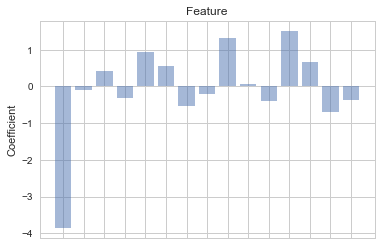

<Figure size 6400x4800 with 0 Axes>

In [52]:
from sklearn import metrics
X_train, X_test, y_train, y_test = get_train_test_data(linear_model.LogisticRegression())
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)
gen_confusion(logreg, X_test)
gen_kfold(linear_model.LogisticRegression(), X_train, y_train)
plot_coef_feature(logreg.coef_[0])

In [53]:
# Time for K Means
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

print_accuracy(knn.predict)

gen_confusion(knn, X_test)
gen_kfold(neighbors.KNeighborsClassifier(), X_train, y_train)

Accuracy = 91.2280701754386%
Accuracy of KNeighborsClassifierclassifier on test set: 0.91
[[101   7]
 [  8  55]]
10-fold cross validation average accuracy: 0.925


In [54]:
# SVM Time - Radial Kernal
svc_radial = svm.SVC(kernel='rbf', probability=True)
svc_radial.fit(X_train, y_train)
print_accuracy(svc_radial.predict)

gen_confusion(svc_radial, X_test)
gen_kfold(svm.SVC(kernel='rbf', probability=True), X_train, y_train, "Radial Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_radial.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 94.73684210526316%
Accuracy of SVCclassifier on test set: 0.95
[[104   4]
 [  5  58]]
10-fold cross validation average accuracy: 0.917


In [55]:
# SVM Time - Sigmoid Kernal
svc_sigmoid = svm.SVC(kernel='sigmoid', probability=True)
svc_sigmoid.fit(X_train, y_train)
print_accuracy(svc_sigmoid.predict)

gen_confusion(svc_sigmoid, X_test)
gen_kfold(svm.SVC(kernel='sigmoid', probability=True), X_train, y_train, "Sigmoid Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_sigmoid.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 63.1578947368421%
Accuracy of SVCclassifier on test set: 0.63
[[108   0]
 [ 63   0]]
10-fold cross validation average accuracy: 0.625


In [77]:
# Get Logistic Regression Feature Selection for the Polynomail kernal
X_train, X_test, y_train, y_test = get_train_test_data(linear_model.LogisticRegression())

[('radius_mean', 1, True), ('texture_mean', 2, False), ('perimeter_mean', 1, True), ('area_mean', 14, False), ('smoothness_mean', 1, True), ('compactness_mean', 6, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 1, True), ('radius_se', 12, False), ('texture_se', 1, True), ('perimeter_se', 15, False), ('area_se', 4, False), ('smoothness_se', 11, False), ('compactness_se', 16, False), ('concavity_se', 3, False), ('concave points_se', 9, False), ('symmetry_se', 7, False), ('fractal_dimension_se', 13, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 5, False), ('area_worst', 10, False), ('smoothness_worst', 1, True), ('compactness_worst', 8, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 1, True)]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scali

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# SVM Time - Polynomial Kernal
svc_poly = svm.SVC(kernel='poly', probability=True)
svc_poly.fit(X_train, y_train)
print_accuracy(svc_poly.predict)

gen_confusion(svc_poly, X_test)
gen_kfold(svm.SVC(kernel='poly', probability=True), X_train, y_train, "Polynomial Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_linear.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 97.07602339181287%
Accuracy of SVCclassifier on test set: 0.97
[[103   5]
 [  0  63]]


In [56]:
# SVM Time - Linear Kernal
svc_linear = svm.SVC(kernel='linear', probability=True)
svc_linear.fit(X_train, y_train)
print_accuracy(svc_linear.predict)


gen_confusion(svc_linear, X_test)
gen_kfold(svm.SVC(kernel='linear', probability=True), X_train, y_train, "Linear Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_linear.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 97.6608187134503%
Accuracy of SVCclassifier on test set: 0.98
[[105   3]
 [  1  62]]
10-fold cross validation average accuracy: 0.965


/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 3, False), ('compactness_mean', 8, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 14, False), ('fractal_dimension_mean', 16, False), ('radius_se', 7, False), ('texture_se', 10, False), ('perimeter_se', 4, False), ('area_se', 1, True), ('smoothness_se', 13, False), ('compactness_se', 12, False), ('concavity_se', 9, False), ('concave points_se', 11, False), ('symmetry_se', 15, False), ('fractal_dimension_se', 6, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 2, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 5, False)]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None

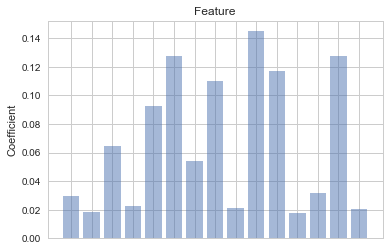

<Figure size 6400x4800 with 0 Axes>

In [57]:
# Random Forest Time
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = get_train_test_data(RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0))
rforest = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, y_train)
print_accuracy(rforest.predict)

gen_confusion(rforest, X_test)
gen_kfold(RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0), X_train, y_train)

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(rforest.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)
plot_coef_feature(rforest.feature_importances_)

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 16, False), ('texture_mean', 13, False), ('perimeter_mean', 12, False), ('area_mean', 11, False), ('smoothness_mean', 10, False), ('compactness_mean', 9, False), ('concavity_mean', 8, False), ('concave points_mean', 1, True), ('symmetry_mean', 5, False), ('fractal_dimension_mean', 2, False), ('radius_se', 1, True), ('texture_se', 1, True), ('perimeter_se', 1, True), ('area_se', 1, True), ('smoothness_se', 1, True), ('compactness_se', 15, False), ('concavity_se', 1, True), ('concave points_se', 4, False), ('symmetry_se', 7, False), ('fractal_dimension_se', 3, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 14, False), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 6, False)]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=N

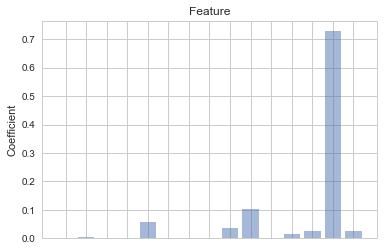

<Figure size 6400x4800 with 0 Axes>

In [58]:
# Decision Tree Time
X_train, X_test, y_train, y_test = get_train_test_data(tree.DecisionTreeClassifier(min_samples_split=2))
dtree = tree.DecisionTreeClassifier(min_samples_split=2)
dtree.fit(X_train, y_train)
print_accuracy(dtree.predict)

gen_confusion(dtree, X_test)
gen_kfold(tree.DecisionTreeClassifier(min_samples_split=2), X_train, y_train)


# TODO Generate these graphs
# shap_values = shap.KernelExplainer(dtree.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)
plot_coef_feature(dtree.feature_importances_)

In [59]:
# Simple Neural Net
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, y_train)
print_accuracy(nn.predict)

gen_confusion(nn, X_test)
gen_kfold(MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0), X_train, y_train)

# explain all the predictions in the test set
# shap_values = shap.KernelExplainer(nn.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 84.7953216374269%
Accuracy of MLPClassifierclassifier on test set: 0.85
[[83 25]
 [ 1 62]]
10-fold cross validation average accuracy: 0.925


In [60]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print_accuracy(gnb.predict)

gen_confusion(gnb, X_test)
gen_kfold(GaussianNB(), X_train, y_train)
# shap_values = shap.KernelExplainer(gnb.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 92.39766081871345%
Accuracy of GaussianNBclassifier on test set: 0.92
[[101   7]
 [  6  57]]
10-fold cross validation average accuracy: 0.947


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 2, False), ('compactness_mean', 10, False), ('concavity_mean', 1, True), ('concave points_mean', 5, False), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 7, False), ('radius_se', 9, False), ('texture_se', 1, True), ('perimeter_se', 6, False), ('area_se', 1, True), ('smoothness_se', 12, False), ('compactness_se', 13, False), ('concavity_se', 14, False), ('concave points_se', 15, False), ('symmetry_se', 11, False), ('fractal_dimension_se', 16, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 3, False), ('concavity_worst', 1, True), ('concave points_worst', 4, False), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 8, False)]
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_interc

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of SGDClassifierclassifier on test set: 0.93
[[104   4]
 [  8  55]]
10-fold cross validation average accuracy: 0.777
[]


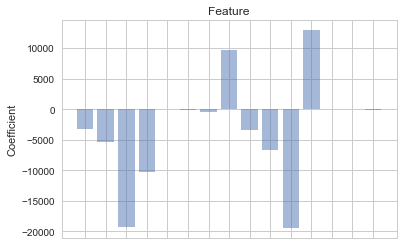

<Figure size 6400x4800 with 0 Axes>

In [61]:
# SGD Classifier
X_train, X_test, y_train, y_test = get_train_test_data(linear_model.SGDClassifier(max_iter=30, tol=1e-3))
clf = linear_model.SGDClassifier(max_iter=30, tol=1e-3)
clf.fit(X_train, y_train)

print_accuracy(clf.predict)

gen_confusion(clf, X_test)
gen_kfold(linear_model.SGDClassifier(max_iter=100, tol=1e-3), X_train, y_train)
plot_coef_feature(clf.coef_[0])

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 2, False), ('compactness_mean', 16, False), ('concavity_mean', 1, True), ('concave points_mean', 6, False), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 4, False), ('radius_se', 10, False), ('texture_se', 1, True), ('perimeter_se', 8, False), ('area_se', 1, True), ('smoothness_se', 12, False), ('compactness_se', 15, False), ('concavity_se', 11, False), ('concave points_se', 14, False), ('symmetry_se', 9, False), ('fractal_dimension_se', 13, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 3, False), ('concavity_worst', 1, True), ('concave points_worst', 7, False), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 5, False)]
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=1, fit_intercep

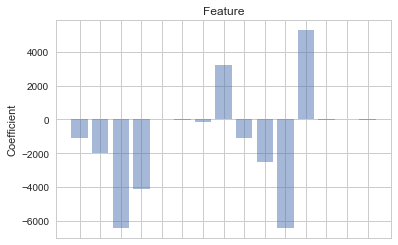

<Figure size 6400x4800 with 0 Axes>

In [62]:
# Perceptron
iteration = 10
X_train, X_test, y_train, y_test = get_train_test_data(linear_model.SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None, max_iter=iteration, tol=1e-3))
clf = linear_model.SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None, max_iter=iteration, tol=1e-3)
clf.fit(X_train, y_train)

print_accuracy(clf.predict)

gen_confusion(clf, X_test)
gen_kfold(linear_model.SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None, max_iter=iteration, tol=1e-3), X_train, y_train)
plot_coef_feature(clf.coef_[0])

Computing regularization path using the LARS ...
.

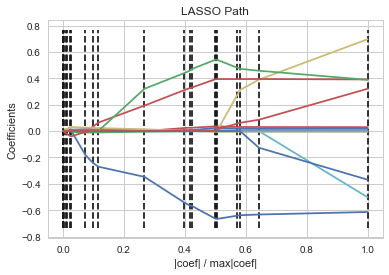

In [63]:

print("Computing regularization path using the LARS ...")
alphas, _, coefs = linear_model.lars_path(X_train.as_matrix(), y_train, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

In [64]:
# Radius Neighbors Classifier
radius = 70
X_train, X_test, y_train, y_test = get_train_test_data(linear_model.LogisticRegression())
rnc = neighbors.RadiusNeighborsClassifier(radius = radius)
rnc.fit(X_train, y_train)

print_accuracy(rnc.predict)

gen_confusion(rnc, X_test)
gen_kfold(neighbors.RadiusNeighborsClassifier(radius = radius), X_train, y_train)

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 1, True), ('texture_mean', 2, False), ('perimeter_mean', 1, True), ('area_mean', 14, False), ('smoothness_mean', 1, True), ('compactness_mean', 6, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 1, True), ('radius_se', 11, False), ('texture_se', 1, True), ('perimeter_se', 15, False), ('area_se', 4, False), ('smoothness_se', 12, False), ('compactness_se', 16, False), ('concavity_se', 3, False), ('concave points_se', 9, False), ('symmetry_se', 7, False), ('fractal_dimension_se', 13, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 5, False), ('area_worst', 10, False), ('smoothness_worst', 1, True), ('compactness_worst', 8, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 1, True)]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scali

In [65]:
# Neartest Shrunken Centroid
clf = neighbors.NearestCentroid(shrink_threshold=.1)
clf.fit(X_train, y_train)

print_accuracy(clf.predict)

gen_confusion(clf, X_test)
gen_kfold(neighbors.NearestCentroid(shrink_threshold=.1), X_train, y_train)

Accuracy = 92.39766081871345%
Accuracy of NearestCentroidclassifier on test set: 0.92
[[104   4]
 [  9  54]]
10-fold cross validation average accuracy: 0.887


In [66]:
# Gaussian Process Classifier - 1.0 * RBF(1.0)
gausc = gaussian_process.GaussianProcessClassifier()
gausc.fit(X_train, y_train)

print_accuracy(gausc.predict)

gen_confusion(gausc, X_test)
gen_kfold(gaussian_process.GaussianProcessClassifier(), X_train, y_train)

Accuracy = 95.32163742690058%
Accuracy of GaussianProcessClassifierclassifier on test set: 0.95
[[102   6]
 [  2  61]]
10-fold cross validation average accuracy: 0.900


[('radius_mean', 7, False), ('texture_mean', 14, False), ('perimeter_mean', 8, False), ('area_mean', 16, False), ('smoothness_mean', 1, True), ('compactness_mean', 1, True), ('concavity_mean', 2, False), ('concave points_mean', 1, True), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 1, True), ('radius_se', 1, True), ('texture_se', 11, False), ('perimeter_se', 4, False), ('area_se', 13, False), ('smoothness_se', 1, True), ('compactness_se', 1, True), ('concavity_se', 1, True), ('concave points_se', 1, True), ('symmetry_se', 3, False), ('fractal_dimension_se', 6, False), ('radius_worst', 5, False), ('texture_worst', 10, False), ('perimeter_worst', 12, False), ('area_worst', 15, False), ('smoothness_worst', 1, True), ('compactness_worst', 9, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 1, True)]
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd',

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of LinearDiscriminantAnalysisclassifier on test set: 0.93
[[107   1]
 [ 11  52]]
10-fold cross validation average accuracy: 0.947
[]


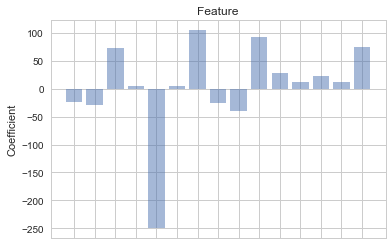

<Figure size 6400x4800 with 0 Axes>

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Linear Discriminant Analysis
X_train, X_test, y_train, y_test = get_train_test_data(LinearDiscriminantAnalysis())
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print_accuracy(lda.predict)

gen_confusion(lda, X_test)
gen_kfold(LinearDiscriminantAnalysis(), X_train, y_train)
plot_coef_feature(lda.coef_[0])

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 4, False), ('compactness_mean', 16, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 11, False), ('fractal_dimension_mean', 8, False), ('radius_se', 5, False), ('texture_se', 10, False), ('perimeter_se', 7, False), ('area_se', 1, True), ('smoothness_se', 13, False), ('compactness_se', 15, False), ('concavity_se', 12, False), ('concave points_se', 6, False), ('symmetry_se', 9, False), ('fractal_dimension_se', 14, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 2, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 3, False), ('fractal_dimension_worst', 1, True)]
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, 

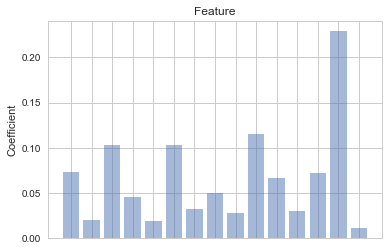

<Figure size 6400x4800 with 0 Axes>

In [68]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
# Extra Trees Classifier
X_train, X_test, y_train, y_test = get_train_test_data(ExtraTreesClassifier())
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

print_accuracy(etc.predict)

gen_confusion(etc, X_test)
gen_kfold(ExtraTreesClassifier(), X_train, y_train)
plot_coef_feature(etc.feature_importances_)

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 10, False), ('texture_mean', 1, True), ('perimeter_mean', 3, False), ('area_mean', 1, True), ('smoothness_mean', 14, False), ('compactness_mean', 1, True), ('concavity_mean', 7, False), ('concave points_mean', 1, True), ('symmetry_mean', 9, False), ('fractal_dimension_mean', 15, False), ('radius_se', 2, False), ('texture_se', 13, False), ('perimeter_se', 8, False), ('area_se', 1, True), ('smoothness_se', 1, True), ('compactness_se', 6, False), ('concavity_se', 4, False), ('concave points_se', 12, False), ('symmetry_se', 16, False), ('fractal_dimension_se', 1, True), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 5, False), ('fractal_dimension_worst', 11, False)]
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss=

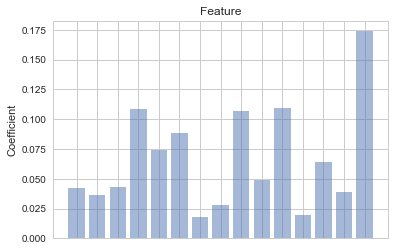

<Figure size 6400x4800 with 0 Axes>

In [69]:
# Gradient Boosting Classifier
X_train, X_test, y_train, y_test = get_train_test_data(GradientBoostingClassifier())
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

print_accuracy(gbc.predict)

gen_confusion(gbc, X_test)
gen_kfold(GradientBoostingClassifier(), X_train, y_train)
plot_coef_feature(gbc.feature_importances_)

In [70]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Quadrati Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

print_accuracy(qda.predict)

gen_confusion(qda, X_test)
gen_kfold(QuadraticDiscriminantAnalysis(), X_train, y_train)

Accuracy = 93.5672514619883%
Accuracy of QuadraticDiscriminantAnalysisclassifier on test set: 0.94
[[102   6]
 [  5  58]]
10-fold cross validation average accuracy: 0.952


In [71]:
# Get Logistic Regression Feature Selection for the Polynomail kernal
X_train, X_test, y_train, y_test = get_train_test_data(linear_model.LogisticRegression())

[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 3, False), ('area_mean', 16, False), ('smoothness_mean', 4, False), ('compactness_mean', 8, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 13, False), ('radius_se', 1, True), ('texture_se', 1, True), ('perimeter_se', 1, True), ('area_se', 1, True), ('smoothness_se', 14, False), ('compactness_se', 12, False), ('concavity_se', 5, False), ('concave points_se', 10, False), ('symmetry_se', 9, False), ('fractal_dimension_se', 15, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 11, False), ('smoothness_worst', 6, False), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 7, False), ('fractal_dimension_worst', 2, False)]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scali

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy = 94.15204678362574%
Accuracy of AdaBoostClassifierclassifier on test set: 0.94
[[101   7]
 [  3  60]]
10-fold cross validation average accuracy: 0.955
[]


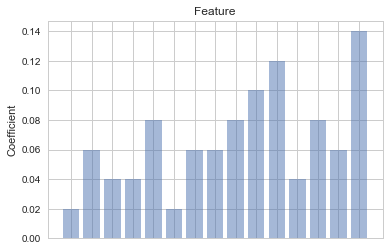

<Figure size 6400x4800 with 0 Axes>

In [72]:
# Ada Classifier
# X_train, X_test, y_train, y_test = get_train_test_data(AdaBoostClassifier())
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

print_accuracy(ada.predict)

gen_confusion(ada, X_test)
gen_kfold(AdaBoostClassifier(), X_train, y_train)
plot_coef_feature(ada.feature_importances_)

In [73]:
labels = [pair[0] for pair in accuracy]
acc = [pair[1] for pair in accuracy]
y_pos = np.arange(len(acc))

<Figure size 6400x4800 with 0 Axes>

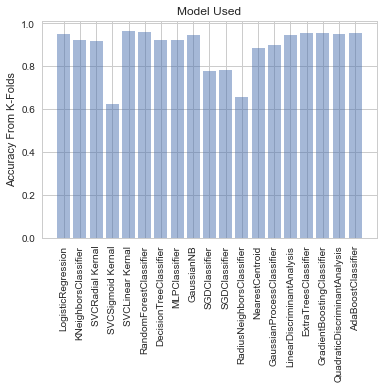

<Figure size 6400x4800 with 0 Axes>

In [74]:
plt.bar(y_pos, acc, align='center', alpha=0.5)
plt.xticks(y_pos, labels, rotation='vertical')
plt.ylabel('Accuracy From K-Folds')
plt.title('Model Used')

plt.figure(num=None, figsize=(80, 60), dpi=80, facecolor='w', edgecolor='k')

In [75]:
acc

[0.9521153846153846,
 0.9247435897435897,
 0.9173076923076924,
 0.625448717948718,
 0.9649358974358975,
 0.9623717948717948,
 0.9221153846153847,
 0.9247435897435897,
 0.9473076923076924,
 0.7769871794871794,
 0.7840384615384616,
 0.6581410256410256,
 0.8869230769230769,
 0.8996153846153847,
 0.9473076923076922,
 0.9549358974358974,
 0.9548076923076924,
 0.9523717948717948,
 0.9548717948717949]

In [76]:
pd.DataFrame({
    'Accuracy': acc,
    'Model': labels
})

,Accuracy,Model
0,0.952115,LogisticRegression
1,0.924744,KNeighborsClassifier
2,0.917308,SVCRadial Kernal
3,0.625449,SVCSigmoid Kernal
4,0.964936,SVCLinear Kernal
5,0.962372,RandomForestClassifier
6,0.922115,DecisionTreeClassifier
7,0.924744,MLPClassifier
8,0.947308,GaussianNB
9,0.776987,SGDClassifier
